In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [6]:
#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

In [7]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [8]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.1, random_state=42)

In [11]:
np.shape(X_train)

(40327, 50)

In [12]:
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

In [13]:
X_train_flat = X_train

In [14]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [15]:
Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()

### Train model

In [16]:
from umap import UMAP

In [17]:
embedder = UMAP(n_components = 64, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=64, verbose=True)
Construct fuzzy simplicial set
Tue Jul 14 11:19:40 2020 Finding Nearest Neighbors
Tue Jul 14 11:19:40 2020 Building RP forest with 14 trees
Tue Jul 14 11:19:42 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Tue Jul 14 11:19:55 2020 Finished Nearest Neighbor Search
Tue Jul 14 11:19:58 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jul 14 11:20:50 2020 Finished embedding


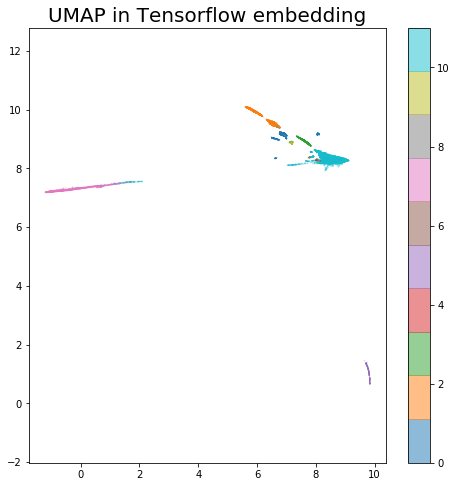

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z_umap[:, 0],
    z_umap[:, 1],
    c=Y_train,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [19]:
import os
import pickle

In [20]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [21]:
output_dir = MODEL_DIR/'projections'/ 'macosko2015' / '64'/ 'umap-learn'
ensure_dir(output_dir)

In [22]:
with open(os.path.join(output_dir, "model.pkl"), "wb") as output:
    pickle.dump(embedder, output, pickle.HIGHEST_PROTOCOL)

In [23]:
np.save(output_dir / 'z.npy', z_umap)